# COMP-767: Reinforcement Learning - Assignment 2

### Imports
The algorithms are in separated python files named **temporal_difference** and **function_approximation**

In [1]:
%load_ext autoreload
%autoreload 2

import gym
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import sys
import multiprocessing

#files containing the core algorithms
import temporal_difference
import function_approximation

## 1. Prediction and control in RL [50 points] 

In this task, you will compare the performance of SARSA, expected SARSA and Q-learning on the Taxi domain from the Gym environment suite:https://gym.openai.com/envs/Taxi-v2/ 
 
 Use a tabular representation of the state space, and ensure that the starting and end location of the passenger are random. Exploration should be softmax (Boltzmann).  You will need to run the following protocol.  You will do 10 independent runs.  Each run consists of 100 segments, in each segment there are 10 episodes of training, followed by 1 episode in which you simply run the optimal policy so far (i.e. you pick actions greedily based on the current value estimates). Pick 3 settings of the temperature parameter used in the exploration and 3 settings of the learning rate. 
 
 You need to plot:
 
* One u-shaped graph that shows the effect of the parameters on the final training performance, expressed as the return of the agent (averaged over the last 10 training episodes and the 10 runs); note that this will typically end up as an upside-down u.
 
* One u-shaped graph that shows the effect of the parameters on the final testing performance, expressed as the return of the agent (during the final testing episode, averaged over the 10 runs)
 
* Learning curves (mean and standard deviation computed based on the 10 runs) for what you pick as the best parameter setting for each algorithm

Write a small report that describes your experiment,  your choices of parameters,  and the conclusions you draw from the graphs.

### Functions necessary to compute the experiment

**get_q** returns a qvalues table for the taxi task

In [2]:
def get_q(env):
    q = {state: np.random.rand(env.action_space.n) for state in range(env.observation_space.n)}

    # q values for terminal states is 0
    for loc_id in range(len(env.locs)):
        loc = env.locs[loc_id]
        s = env.encode(loc[0], loc[1], loc_id, loc_id)
        q[s] = np.zeros(env.action_space.n)
    
    return q

**test_optimal_policy** runs a greedy policy on a given qtable

In [3]:
def test_optimal_policy(q, env, discount_rate=0.9, show=True):
    policy_greedy = temporal_difference.Greedy(n=env.action_space.n)
    s = env.reset()
    a = policy_greedy.get_action(q, s)
    history = temporal_difference.History(s, a, discount_rate)
    done = False
    
    if show : 
        env.render()
        
    while not done:
        observation, reward, done, info = env.step(a)
        s = observation
        a = policy_greedy.get_action(q, s)
        history.register(s, a, reward)
        if show : 
            env.render()
            print(f"Timestep: {history.t}, Reward: {reward}, Total reward: {history.undiscounted_return()}, Discounted reward: {history.discounted_return()}")
    return history

**run** performs trains a random initial qtable of the taxi gym task for a given number of segments. A segment is given number of episode. After each segment, **test_optimal_policy** is runs to log the undiscounted reward of an episode folowing a greedy policy. **run** returns *training_results* that is the sequence of undiscounted rewards for each training episode and *testing_results* that is the sequence of undiscouted reward of each testing episode

In [4]:
def run(update_algorithm, 
        temperature_factor=1, 
        learning_rate=0.5, 
        n_segment=100, 
        episode_by_segment=10, 
        discount_rate = 0.9, 
        show=False, 
        print_segment=False):
    
    exploration_policy = temporal_difference.SoftmaxExploration(temperature_factor=temperature_factor)
    env = gym.make('Taxi-v2')
    q = get_q(env.unwrapped)
    
    training_results=[]
    testing_results = []
    for segment in range(n_segment):
        for episode in range(episode_by_segment):
            episode_history = update_algorithm(env, exploration_policy, q, learning_rate, discount_rate)
            training_results.append(episode_history.undiscounted_return())
        
        testing_history = test_optimal_policy(q, env, discount_rate, show)
        testing_results.append(testing_history.undiscounted_return())
        
        if print_segment:
            print("Segment : %2i, Timestep : %3i, Total reward : %5i" % (segment, 
                                                                         testing_history.t, 
                                                                         testing_history.undiscounted_return()))
    return training_results, testing_results


training_results, testing_results = run(temporal_difference.qlearning_update, print_segment=True, n_segment=10)

Segment :  0, Timestep : 200, Total reward : -2000
Segment :  1, Timestep : 200, Total reward :  -200
Segment :  2, Timestep : 200, Total reward :  -200
Segment :  3, Timestep : 200, Total reward :  -200
Segment :  4, Timestep : 200, Total reward :  -200
Segment :  5, Timestep : 200, Total reward : -1991
Segment :  6, Timestep : 200, Total reward :  -200
Segment :  7, Timestep : 200, Total reward :  -200
Segment :  8, Timestep : 200, Total reward :  -200
Segment :  9, Timestep : 200, Total reward :  -200


**experiment** computes **run** the number of times it is asked in the problem for a given *temparature_factor* and *learning_rate*

In [5]:
def experiment(update_algorithm, temparature_factor, learning_rate):
    n_run = 10
    n_segment=100
    episode_by_segment=10
    
    train = np.zeros((n_run, n_segment*episode_by_segment))
    test = np.zeros((n_run,n_segment))
    for i in range(n_run):
        train[i,:], test[i,:] = run(update_algorithm, temparature_factor, learning_rate, n_segment, episode_by_segment)
    
    return train, test

Thes functions compute **experiment** for all the combinations of *temperature_factors* and *learning_rates* and filter them in an easy to plot sequence. I do the computation in parallel because it was very slow otherwise on my laptop

In [6]:
def algorithm_parameters_effect_parallel(update_algorithm, learning_rates, temperature_factors):
    print(update_algorithm)
    sys.stdout.flush()
    p = multiprocessing.Pool(multiprocessing.cpu_count()-1)

    settings=[]
    for temparature_factor in temperature_factors:
        for learning_rate in learning_rates:
            settings.append((algorithms[update_algorithm], temparature_factor, learning_rate))
    return p.starmap(experiment, settings)
    

def filter_parallel_results(r):
    train, test = [], []
    for train_, test_ in r:
        train.append(np.mean(train_[:,-10:]))
        test.append(np.mean(test_[:,-1:]))
    
    train = np.array(train).reshape(3,3)
    test = np.array(test).reshape(3,3)
    
    return train, test

### Funtions to exctract usefull information from the experiment

**get_best** returns the *learning_rate* and the *temperature factor* that gives the best undiscounted return during testing

In [7]:
def get_best(test, learning_rates, temperature_factors):
    argmax = test.argmax()
    tf_index, lr_index = np.unravel_index(argmax, test.shape)
    return test[tf_index, lr_index], learning_rates[lr_index], temperature_factors[tf_index], argmax

**get_learning_curve** computes the mean undiscounted reward during traing and its ascociated stadard deviation along all the runs in an experiment

In [8]:
def get_learning_curve(r, amax, train=True):
    data = r[amax][0] if train else r[amax][1]
    return np.mean(data, axis=0), np.std(data, axis=0)

### Plotting functions

These function plot the returns during training and testing for all the combinations of *temperature_factors* and *learning_rates* and the learning curve for the best tuple (temperature_factor, learning_rate)

In [9]:
def subplot(name, algo, results, learning_rates, temperature_factors):
    for i in range(len(results)):
        plt.plot(learning_rates, results[i,:], label=temperature_factors[i])
    plt.legend()
    plt.title(algo + " during " + name)
    plt.xlabel("learning rate")
    plt.ylabel("Cumulative reward")
    
def plot_parameter_effect(algo, train, test, learning_rates, temperature_factors):
    fig = plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    subplot("training", algo, train, learning_rates, temperature_factors)

    plt.subplot(1, 2, 2)
    subplot("testing", algo, test, learning_rates, temperature_factors)
    plt.show()
    
def plot_learning_curve(mean, std):    
    fig = plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(mean)
    plt.title("Mean return during training")
    plt.xlabel("learning step")
    plt.ylabel("Mean")

    plt.subplot(1, 2, 2)
    plt.plot(std)
    plt.title("Standard deviation of the return during training")
    plt.xlabel("learning step")
    plt.ylabel("Standard deviation")
    
    plt.show()
    
def plot_q1_results(update_algorithm, train, test, best_return, best_lr, best_tf, mean, std):
    plot_parameter_effect(update_algorithm, train, test, learning_rates, temperature_factors)
    print(f"Best return : {best_return}, learning rate = {best_lr}, and temperature factor = {best_tf} \n")
    plot_learning_curve(mean, std)

### The results are computed here !

SARSA


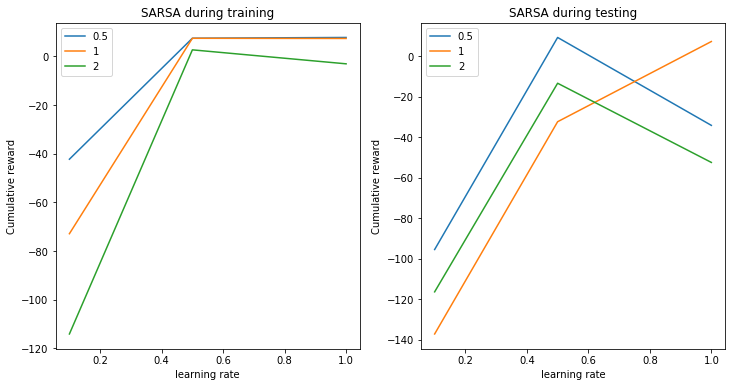

Best return : 9.3, learning rate = 0.5, and temperature factor = 0.5 



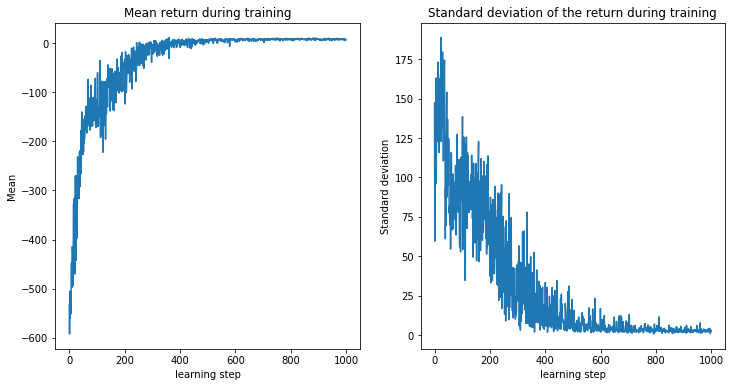

Expected SARSA


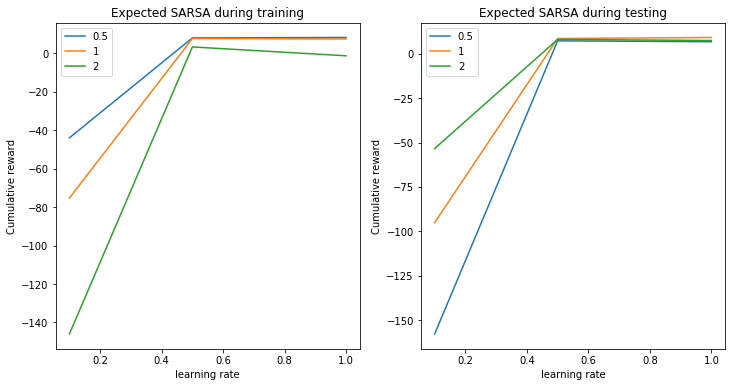

Best return : 9.2, learning rate = 1, and temperature factor = 1 



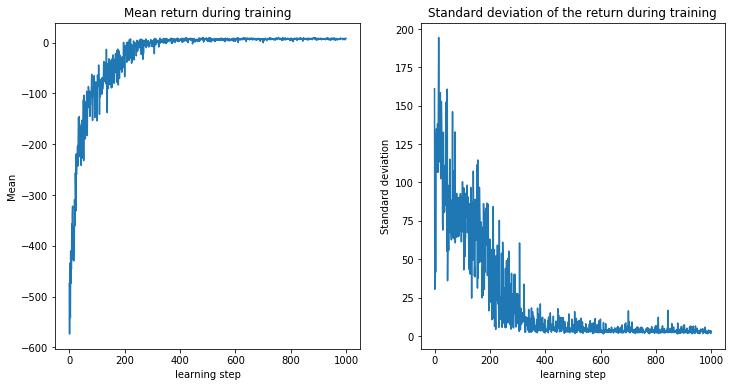

Q-learning


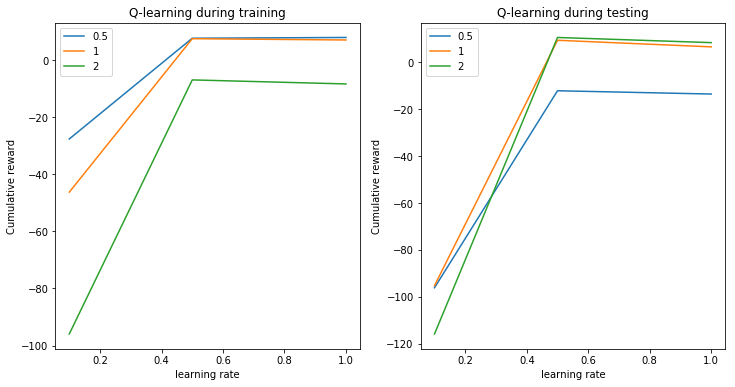

Best return : 10.5, learning rate = 0.5, and temperature factor = 2 



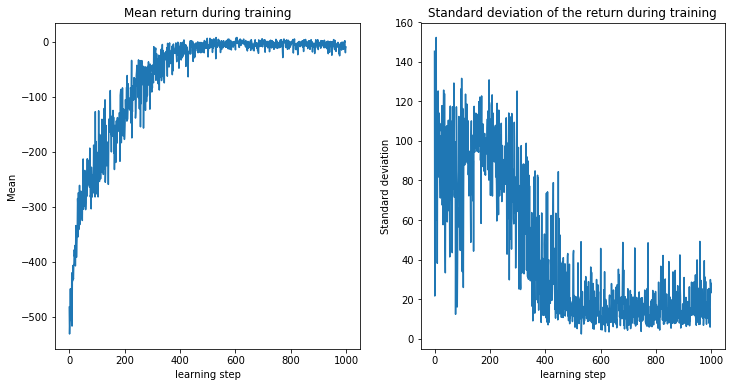

In [10]:
def parameters_effect(algo, learning_rates, temperature_factors):
    r = algorithm_parameters_effect_parallel(algo, learning_rates, temperature_factors)
    train, test = filter_parallel_results(r)
    best_return, best_lr, best_tf, amax = get_best(test, learning_rates, temperature_factors)
    mean, std = get_learning_curve(r, amax, train=True)
    plot_q1_results(algo, train, test, best_return, best_lr, best_tf, mean, std)
    
algorithms = {"SARSA":temporal_difference.sarsa_update, 
              "Expected SARSA": temporal_difference.expected_sarsa_update, 
              "Q-learning":temporal_difference.qlearning_update}
temperature_factors= [0.5, 1, 2]
learning_rates = [0.1, 0.5, 1]

for algo in algorithms:
    parameters_effect(algo, learning_rates, temperature_factors)

## Q1 - Report
For all situation i choose a discount rate of 0.9.

Observations
* During training if the temperature factor is high, in this case 2, the performance will be far below lower temperature factors.
* For all algorithms, the best training combinaison of learning rate et temperature factor is not the best during testing time.
* Expected Sarsa has a lower standard deviation during training of the best combinaison of parameters of all the algorithms, this is not surprising because is uses expected update instead of sample updates for two other algorihms.
* Expected Sarsa seams to be more robust, this is because performance does not seam to change very much when the temperature factor varies
* Q-learning has the best return and a higher training standard deviation of all the algorithms, this is not surpsisong because it is an off-policy methods unlike the other two.
* There seams to be a trade-off between variance/robusteness and best mean reward, between Expected Sarsa and Q-Learning.

# 2. Function approximation [50 points]
Implement and compare empirically Monte Carlo and TD-learning with eligibility traces and linear function approximation on the Pendulum-v0 domain from the Gym environment suite:https://gym.openai.com/envs/Pendulum-v0/ 

You should evaluate the fixed policy that produces torque in the same direction as the current velocity with probability 0.9 and in the opposite direction with probability 0.1. If velocity is 0, you can torque in a random direction. 

For this experiment, you should use a tile coding function  approximator, in which you discretize  the  angular  position  and angular velocity into 10 bins each, and use 5 overlapping tilings, whose weights start initialized randomly between −0.001 and 0.001. 

You will need to use the same seed for this initialization for all parameters settings, but will have 10 different seeds (for the different runs). You should use values of λ={0, 0.3, 0.7, 0.9, 1}. For each value, use 3 settings of the learning rate parameter α = {1/4, 1/8, 1/16}. Remember that the learning rate per parameter needs to be divided by the number of overlapping tilings. 

Perform 10 independent runs, each of 200 episodes. Each episode should start art state (0,0).  Plot 5 graphs, one for each of the λ-values, showing the value of the start state, using each of the α-values (each of the 5 graphs has 3 curves). Explain briefly what you can conclude from these graphs, in terms of the speed of convergence and stability of these algorithms.

### Functions necessary to compute the experiment

In [11]:
def policy(env, state, action_amplitude = None):
    probability_torque_same_direction = 0.9
    velocity = state[1]
    
    if action_amplitude == None or action_amplitude > env.unwrapped.max_torque:
        action_amplitude = env.unwrapped.max_torque
        
    direction = 1 if velocity >= 0 else -1
        
    action = np.array([action_amplitude * direction])
    
    p = np.random.rand(1)
    if p > probability_torque_same_direction:
        action *= -1
    return action

def get_angle_velocity(observation):
    angle = np.arccos(observation[0])
    if observation[1] < 0:
        angle = 2 * np.pi - angle
    velocity = observation[2]
    return angle, velocity

def get_weights(size, weights_max_initial_range = 0.001, seed = None):
    np.random.seed(seed)
    return np.random.rand(size) * weights_max_initial_range * 2 - weights_max_initial_range

In [12]:
def reset_env(env):
    env.reset()
    env.unwrapped.state = np.array([0,0])
    return env.unwrapped._get_obs()

def q2_run(lambda_return, learning_rate, n_episode_by_run, n_bins, n_tilings, prediction_algorithm, seed = None):

    env = gym.make('Pendulum-v0')
    env.reset()
    discount_rate=0.9
    low = np.array([0.0, -env.unwrapped.max_speed])
    high = np.array([2*np.pi, env.unwrapped.max_speed])
    state_observation_space = gym.spaces.Box(low=low, high=high, dtype=np.float32)
    approximation_function = function_approximation.TileCoding(n_bins=n_bins, 
                                                             n_tilings=n_tilings,
                                                             observation_space = state_observation_space)
    weights = get_weights(approximation_function.size, seed=seed)
    
    state_to_estimate = np.array([0,0])
    approximate_value = [approximation_function(state_to_estimate, weights)]
    for episode in range(n_episode_by_run):
        weights = prediction_algorithm(env, policy, 
                                        learning_rate=learning_rate/n_tilings, 
                                        discount_rate=discount_rate,
                                        lambda_return=lambda_return, 
                                        approximation_function=approximation_function, 
                                        weights = weights, 
                                        state_from_observation_function= get_angle_velocity, 
                                        reset_function = reset_env)
        approximate_value.append(approximation_function(state_to_estimate, weights))
        
    return approximate_value

q2_run(lambda_return=0.5, learning_rate=0.1, 
       n_episode_by_run=10, n_bins=10, n_tilings=5, 
       prediction_algorithm = temporal_difference.semi_gradient_td_update, seed=1)

[0.0009114213459844564,
 -0.11746325758013479,
 -0.2766333776302015,
 -0.4312276243215175,
 -0.7192910948591587,
 -1.0286367547065551,
 -1.4897131437561528,
 -1.8998281458793207,
 -2.5492599374677423,
 -3.145434493912861,
 -3.785471878294369]

In [13]:
def q2_experiment(lambda_returns, learning_rates, n_run = 10,
       n_episode_by_run=10, n_bins=10, n_tilings=5, 
       prediction_algorithm = temporal_difference.semi_gradient_td_update):
    results={}
    for lambda_return in lambda_returns:
        results[lambda_return] = {}
        for learning_rate in learning_rates:
            runs = np.zeros((n_run, n_episode_by_run+1))
            for run in range(n_run):
                runs[run,:] = q2_run(lambda_return, learning_rate,n_episode_by_run, n_bins, 
                                     n_tilings, prediction_algorithm, seed=run)
            results[lambda_return][learning_rate] = np.mean(runs, axis=0)
    return results

In [14]:
def q2_experiment_parallel(lambda_returns, learning_rates, n_run = 10,
       n_episode_by_run=10, n_bins=10, n_tilings=5, 
       prediction_algorithm = temporal_difference.semi_gradient_td_update):
    
    p = multiprocessing.Pool(multiprocessing.cpu_count()-1)

    settings=[]
    for lambda_return in lambda_returns:
        for learning_rate in learning_rates:
            for run in range(n_run):
            
                settings.append((lambda_return, learning_rate, n_episode_by_run, 
                                n_bins,n_tilings, prediction_algorithm, run))
    parallel_results = p.starmap(q2_run, settings)
    
    results = {}
    for lambda_return in lambda_returns:
        results[lambda_return]= {}
        for learning_rate in learning_rates:
            results[lambda_return][learning_rate] = np.mean(parallel_results[:n_run], axis=0)
            del parallel_results[:n_run]
            
    return results

### Plotting functions

In [15]:
def lambda_plot(results, lambda_return):
    for learning_rate in results[lambda_return]:
        plt.plot(results[lambda_return][learning_rate], label=r"$\alpha$"+f"={learning_rate}")
    plt.title(f"Estimated value of state {(0,0)} when $\lambda$={lambda_return}")
    plt.xlabel("Episodes")
    plt.ylabel("Estimated Value")
    plt.legend()
    
def all_lambda_plot(results):
    fig = plt.figure(figsize=(18, 10))
    lambda_returns = list(results.keys())
    for i in range(len(results)):
        plt.subplot(2, 3, i+1)
        lambda_plot(results, lambda_returns[i])
    plt.show()

### The results are computed here !

In [16]:
lambda_returns = [0, 0.3, 0.7, 0.9, 1]
learning_rates = [1/4, 1/8, 1/16]

n_run = 10
n_episode_by_run = 200
n_bins = 10
n_tilings = 5

This a test with semi_gradient_td_update

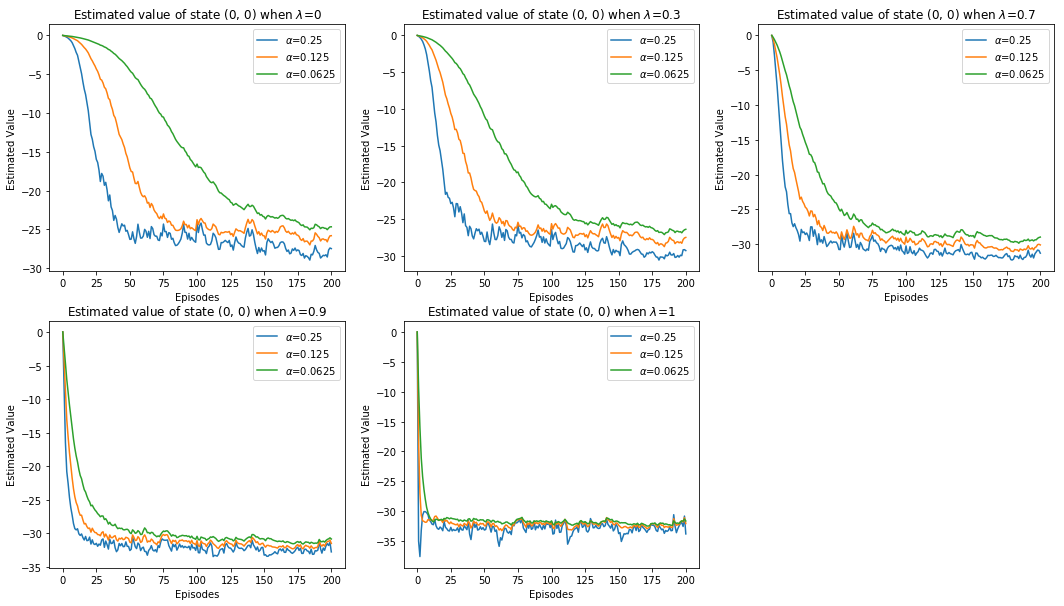

In [17]:
results_semi_gradient_td_update = q2_experiment_parallel(lambda_returns, learning_rates, n_run, n_episode_by_run,
                                                         n_bins, n_tilings, temporal_difference.semi_gradient_td_update)
all_lambda_plot(results_semi_gradient_td_update)

This a test with true_online_td_update

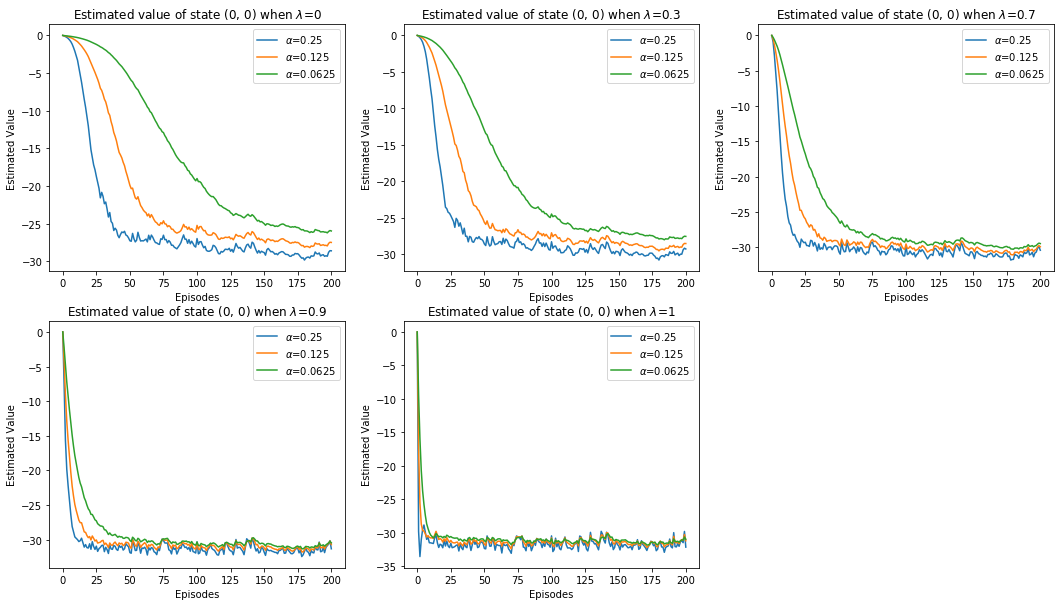

In [18]:
results_true_online_td_update = q2_experiment_parallel(lambda_returns, learning_rates, n_run, n_episode_by_run,
                                                         n_bins, n_tilings, temporal_difference.true_online_td_update)
all_lambda_plot(results_true_online_td_update)

## Q2 - Report
For all situation i choose a discount rate of 0.9. For repetability, I used seed initilization. The seeds I used where the index of the run, this way I will get the same initial parameters for each combinaison of parameters.

Observations:
* The higher $\lambda$ is the faster the convergence of the algorithm. I think this is due to the fact that the initial state will not appear in the simulation after the first step because the speed of the pendulum increase until it reachs saturation never going back to 0.

* The lower $\alpha$ is, slower is the convergence of the algorithm, but reduce the chance of overshoot of the estimation of the value function at the intial state

* The algorithm True-Online TD to be a better algorithm then Semi-Gradient TD. It seams to learn in the same way but in a smoother way, behing more robust. 